In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.colors as mcolors
import matplotlib.path as mpath
from matplotlib.ticker import MaxNLocator
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches



In [2]:
def load_trend_data(variable, model, experiment, period):
    #loads in the trend data
    #factor to convert trend data from Pa/year to hPa
    conversion_factor = 1.65
    
    #slice trend to the N. Atlantic
    lat_range = slice(20, 80)
    lon_range = slice(-90, 40)
    
    filepath = f"{base_dir}/trend_calc_LESFMIP/linear_regression/NAO/{experiment}/{model}/psl_mon_{experiment}_{model}_DJF_linear_trend_{period}_stats.nc"
    return xr.open_dataset(filepath).sel(lat=lat_range, lon=lon_range) * conversion_factor

def load_proj_or_resid_data(variable, result, mode, model, experiment, period):
    #loads in the projected or residual data
    #mode is NAO/EA, result is proj/res
    filepath = f"{base_dir}/projection_indicies/NAtlantic_forced_trends/{experiment}/{model}/psl_mon_{experiment}_{model}_DJF_{mode}_{result}_{period}.nc"
    return xr.open_dataset(filepath)

def load_reg_pattern(mode, model, experiment, period):
    filepath = f"{base_dir}/regression_patterns/{mode}/psl_mon_{experiment}_{model}_DJF_{mode}_regression_map_{period}.nc"
    return xr.open_dataset(filepath)

def get_min_max(data_dict, variable):
    #finds the max and min values of the data
    values_min = [np.min(data[variable]) for data in data_dict.values()]
    values_max = [np.max(data[variable]) for data in data_dict.values()]
    return min(values_min), max(values_max)


In [3]:
#once ran for all models could be good to link with the plots - e.g. either save this or calculate with the other plots
#and like generate each plot.
#base directory/home directory
base_dir = '/gws/nopw/j04/extant/users/slbennie'

#time to find the right files
#also time that is right for the plots
period = '1850-2015'
period_title = '1850-2014'

#creating lists for models, exp and modes.
models = ['HadGEM3-GC31-LL', 'CanESM5', 'MPI-ESM1-2-LR', 'MIROC6', 'NorESM2-LM']
experiments = ['historical', 'hist-aer', 'hist-GHG', 'hist-sol', 'hist-totalO3', 'hist-volc']
modes = ['NAO', 'EA']

#Initialize an empty array to store r2 scores:
#Dimensions: model x experiment x mode
r2_array = np.full((len(models), len(experiments), len(modes)), np.nan)

for i_m, m in enumerate(models):
    #loading in the data
    trend_data = {e: load_trend_data('psl', m, e, period) for e in experiments}
    proj_data_NAO = {e: load_proj_or_resid_data('psl', 'projection', 'NAO', m, e, period) for e in experiments}
    proj_data_EA  = {e: load_proj_or_resid_data('psl', 'projection', 'EA', m, e, period) for e in experiments}

    #finding the r^2 values
    for i_e, e in enumerate(experiments):
        trend_array = trend_data[e]['slope'].values.flatten()
        trend_total_variance = np.sum(trend_array ** 2)

        proj_NAO = proj_data_NAO[e]['projection_NAO_djf'].values.flatten()
        proj_EA = proj_data_EA[e]['projection_EA_djf'].values.flatten()

        r2_NAO = np.sum(proj_NAO ** 2) / trend_total_variance
        r2_EA = np.sum(proj_EA ** 2) / trend_total_variance

        r2_array[i_m, i_e, 0] = r2_NAO  # NAO mode
        r2_array[i_m, i_e, 1] = r2_EA   # EA mode

#Create xarray DataArray
r2_scores = xr.DataArray(
    r2_array,
    coords={
        'model': models,
        'experiment': experiments,
        'mode': modes
    },
    dims=['model', 'experiment', 'mode'],
    name='r_squared'
)

# Example: print r² for all
#print(r2_scores)



/tmp/ipykernel_534/390893774.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(experiments, rotation=45, ha='right')
/tmp/ipykernel_534/390893774.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(experiments, rotation=45, ha='right')


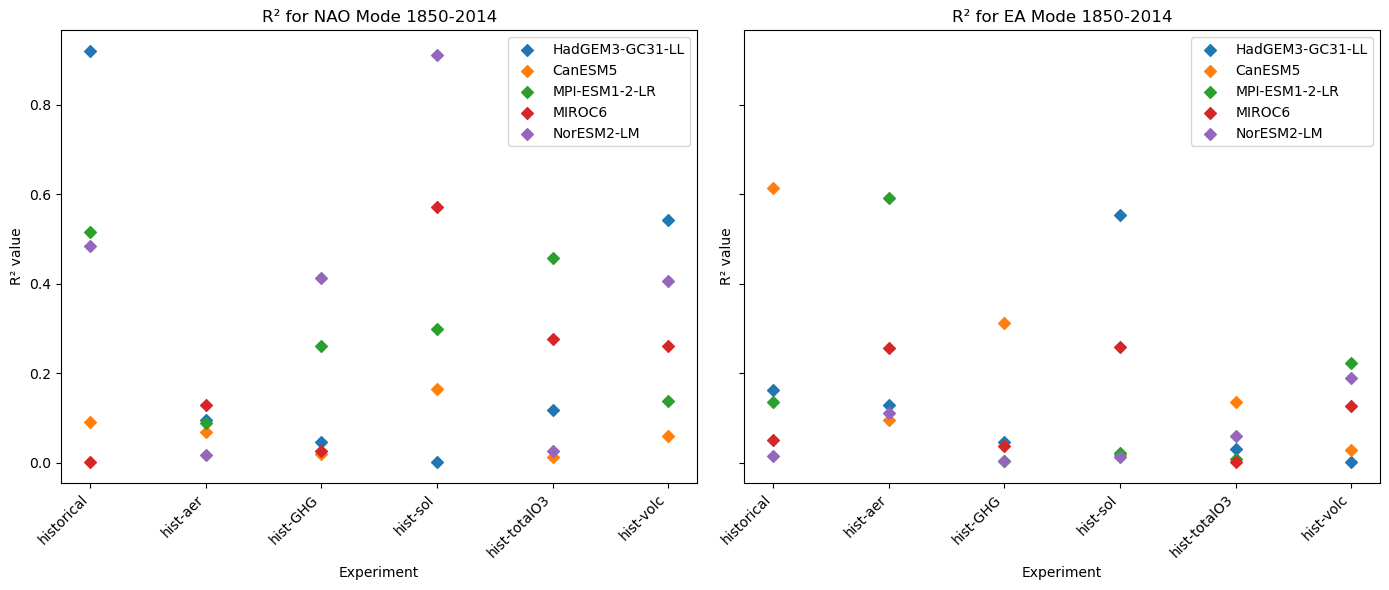

In [4]:
#plotting the R^2
modes = ['NAO', 'EA']
models = r2_scores.coords['model'].values
experiments = r2_scores.coords['experiment'].values

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for i, mode in enumerate(modes):
    ax = axes[i]
    for model in models:
        # Extract r2 for this mode and model for all experiments
        y = r2_scores.sel(model=model, mode=mode).values
        ax.scatter(experiments, y, marker='D', label=model)

    ax.set_title(f"R² for {mode} Mode {period_title}")
    ax.set_xlabel("Experiment")
    ax.set_ylabel("R² value")
    ax.set_xticklabels(experiments, rotation=45, ha='right')
    ax.legend()

plt.tight_layout()
plt.savefig('Figures/R2_all_models.png', bbox_inches='tight')
plt.show()

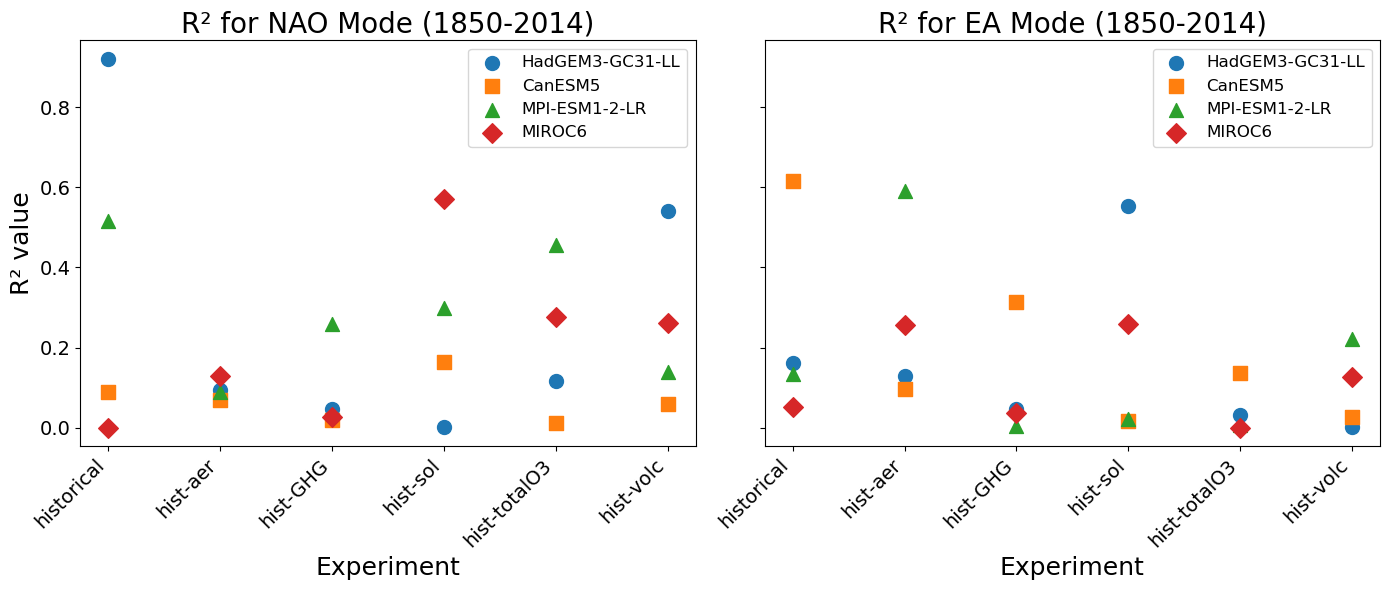

In [14]:
modes = ['NAO', 'EA']
models = r2_scores.coords['model'].values
experiments = r2_scores.coords['experiment'].values

# Define a list of unique markers (as many as your number of models)
marker_styles = ['o', 's', '^', 'D', 'v', 'P', '*', 'X', 'h', '1']

# Map each model to a unique marker
model_markers = {model: marker_styles[i % len(marker_styles)] for i, model in enumerate(models)}

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for i, mode in enumerate(modes):
    ax = axes[i]
    for model in models:
        # Extract r² values
        y = r2_scores.sel(model=model, mode=mode).values
        # Use the model-specific marker
        ax.scatter(experiments, y, marker=model_markers[model], label=model, s=100)

    ax.set_title(f"R² for {mode} Mode ({period_title})", fontsize=20)
    if i==0:
        ax.set_ylabel("R² value", fontsize=18)
    ax.set_xlabel("Experiment", fontsize=18)
    ax.set_xticks(range(len(experiments)))
    ax.set_xticklabels(experiments, rotation=45, ha='right', fontsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.legend(loc='upper right', fontsize=12)

plt.tight_layout()
plt.savefig('Figures/R2_all_models.png', bbox_inches='tight')
plt.show()


HadGEM3-GC31-LL
-4.741853571465333 4.124283494351493


NameError: name 'NAO_EOF' is not defined

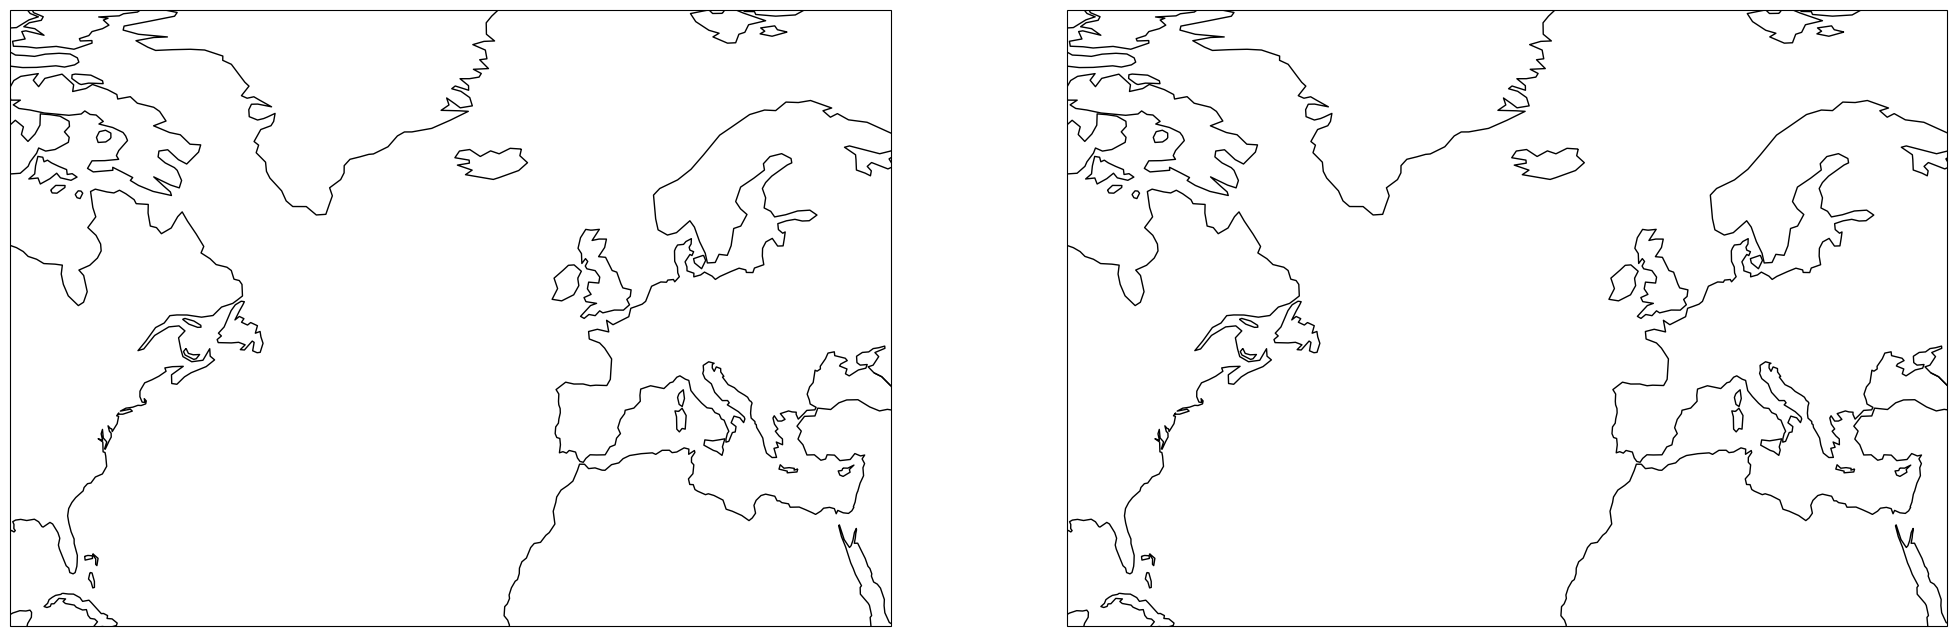

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25,8), subplot_kw={'projection': ccrs.PlateCarree()})
cmap = 'seismic'

print(models[0])
NAO_pattern = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/regression_patterns/NAO/historical/'+models[0]+'/psl_mon_historical_'+models[0]+'_DJF_NAO_regression_map_'+period+'.nc')
EA_pattern = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/regression_patterns/EA/historical/'+models[0]+'/psl_mon_historical_'+models[0]+'_DJF_EA_regression_map_'+period+'.nc')

min_NAO = np.min(NAO_pattern['regression_NAO_djf'].values)
max_NAO = np.max(NAO_pattern['regression_NAO_djf'].values)

min_EA = np.min(EA_pattern['regression_EA_djf'].values)
max_EA = np.max(EA_pattern['regression_EA_djf'].values)

min_pattern = min(min_NAO, min_EA)
max_pattern = max(max_NAO, max_EA)

lon_NAO = NAO_pattern['lon'].values
lat_NAO = NAO_pattern['lat'].values

lon_EA = EA_pattern['lon'].values
lat_EA = EA_pattern['lat'].values

print(min_pattern,max_pattern)

norm_pattern = mcolors.TwoSlopeNorm(vmin=min_pattern, vcenter=0, vmax=max_pattern)
levels = np.arange(-5.2,5.6,0.4)


#dummy_data = np.array([[min_EOF, max_EOF], [min_EOF, max_EOF]])
#dummy_cont = ax[0].contourf([0,1], [0,1], dummy_data, cmap=cmap, norm=norm_EOF)#, levels=levels)
#norm_pattern = norm_all

# Map extent
lon_min, lon_max = -90, 40
lat_min, lat_max = 20, 80

# Plot
for i in range(2):
    #)
    ax[i].set_xlabel('lon')
    ax[i].set_ylabel('lat')
    ax[i].add_feature(cfeature.COASTLINE, linewidth=1, edgecolor='black')
    ax[i].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax[i].set_aspect('auto')

# Add colorbar (reusing dummy contour is still fine)

contour = ax[0].contourf(lon_NAO, lat_NAO, (-1*NAO_EOF['regression_NAO_djf']).squeeze(), cmap=cmap, norm=norm_pattern, levels=levels, transform=ccrs.PlateCarree())
ax[1].contourf(lon_EA, lat_EA, EA_EOF['regression_EA_djf'].squeeze(), cmap=cmap, norm=norm_pattern, levels=levels, transform=ccrs.PlateCarree())

cax = fig.add_axes([0.01, -0.1, 0.9, 0.1])
cbar = fig.colorbar(contour, cax=cax, orientation='horizontal')
cbar.set_label('hPa/unit PC', fontsize=22)
cbar.ax.tick_params(direction='in', length=10, width=2, labelsize=22)
ax[0].set_title('North Atlantic Oscillation', fontsize=26)
ax[0].set_title('a)', loc='left', fontsize=26)
ax[1].set_title('East Atlantic Pattern', fontsize=26)
ax[1].set_title('b)', loc='left', fontsize=26)


# Add overall labels and title
fig.suptitle(f"Regression patterns for {model[0]}'s historical experiment ({period_title})", fontsize=30)
plt.tight_layout(rect=[0,0,0.91,0.97])
plt.savefig(f'Figures/NAO_EA_regression_patterns_{model[0]}_{period_title}.png', bbox_inches='tight')
plt.show()